# 4. 이미지 어디까지 우려볼까?


## Augmentation 적용
### (1) 데이터 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


이번 노드에서는 augmentation을 텐서플로우 모델 학습에 어떻게 적용할 수 있는지 공부하겠습니다. 지금까지 모델을 훈련시키기 전, 데이터를 전처리해 입력값으로 사용해 오셨을 것입니다. Augmentation도 이처럼 입력 이미지의 데이터를 변경해 주는 과정이므로 일반적인 이미지 데이터 전처리 방법과 활용방법이 동일합니다. 먼저 필요한 라이브러리들을 불러와 줍니다.

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import os
import pandas as pd

In [3]:
# 학습 전에는 항상 GPU 환경을 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

* 사용할 데이터셋을 불러옵니다. 이번 시간에는 stanford_dogs 데이터셋을 사용해보도록 합시다.
* stanford_dogs 데이터셋에는 120개 견종의 이미지가 포함되어 있습니다.
* 총 20,580장의 이미지에서 12,000장은 학습셋, 나머지 8,580장은 평가용 데이터셋.

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete801P28/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete801P28/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


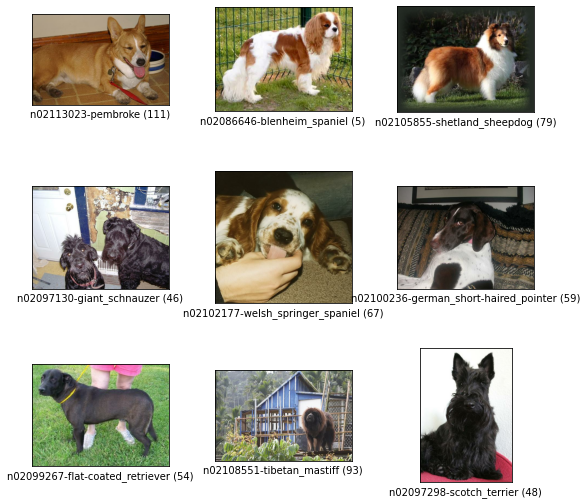

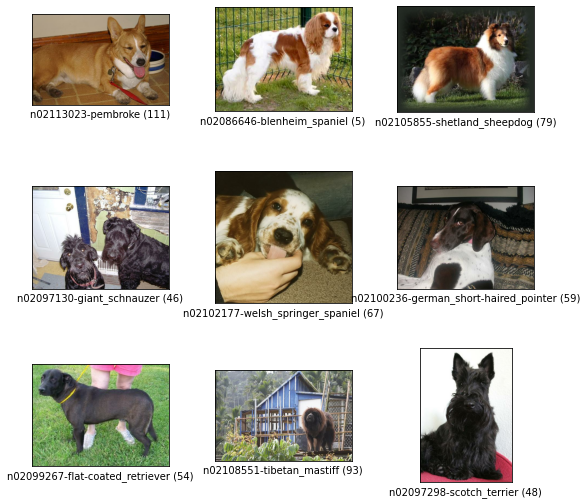

In [5]:
# 다운로드한 데이터를 확인
tfds.show_examples(ds_train, ds_info)

### (2) Augmentation 적용하기
#### 텐서플로우 Random Augmentation API 사용하기
많은 augmentation 기법들이 있지만 그중에서 텐서플로우 API로 바로 사용할 수 있는 방법들을 먼저 적용해 보겠습니다. 먼저 이미지셋에 대해서 랜덤한 확률로 바로 적용할 수 있는 augmentation 함수들은 아래와 같습니다.

* random_brightness()
* random_contrast()
* random_crop()
* random_flip_left_right()
* random_flip_up_down()
* random_hue()
* random_jpeg_quality()
* random_saturation()

In [6]:
#이미지 변환 전처리 함수

def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    
    return tf.cast(image, tf.float32) / 255., label   #normalizing

#Argumentation 랜덤 적용 - flip,brightness
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    
    return image, label


#데이터 가공 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  #기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       #augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [7]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

## 심화 기법
### (1) Cutmix Augmentation

지금부터 조금 더 복잡한 augmentation 방법을 알아보겠습니다.

첫 번째는 CutMix augmentation입니다.

* [CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features](https://arxiv.org/pdf/1905.04899.pdf)

* Chris Deotte's CutMix and MixUp on GPU/TPU(https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu)

CutMix는 네이버 클로바(CLOVA)에서 발표한 CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features 에서 제안된 방법입니다. 이름인 CutMix를 보고 유추할 수 있듯 이미지 데이터를 자르고 섞는다고 생각할 수 있습니다.

아래 표에서 ResNet-50 컬럼은 우리가 일반적으로 사용해왔던 방식을 나타냅니다. Mixup은 특정 비율로 픽셀별 값을 섞는 방식이고, Cutout은 이미지를 잘라내는 방식입니다. CutMix는 Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법입니다. 차에 비유하면 블렌딩 같은 방법이죠.

두 번째 링크인 Chris Deotte's CutMix and MixUp on GPU/TPU에서는 캐글 그랜드마스터인 Chris Deotte가 구현한 CutMix와 MixUp을 확인 할 수 있습니다. 남은 스텝에서 CutMix와 MixUp을 구현하면서 참고하도록 합시다. 참고로 캐글에서 지금 참가하고 있는 대회와 비슷한 태스크의 경진대회가 있는 경우, 다른 사람들이 적용한 방법들을 찾아보는 것도 인사이트를 얻는 데 좋습니다.

CutMix는 이미지를 섞는 부분과 섞은 이미지에 맞추어 라벨을 섞는 부분을 포함합니다. 이제 한 부분씩 구현해 보겠습니다.

![img](https://d3s0tskafalll9.cloudfront.net/media/images/GC-2-P-2.max-800x600.png)

#### 1) 이미지 섞기
가장 먼저 두 개의 이미지를 섞어주는 것부터 생각해 봅시다. 배치 내의 이미지를 두 개 골라서 섞어줍니다. 이때 이미지에서 잘라서 섞어주는 영역을 바운딩 박스(bounding box)라고 부릅니다.

예시를 위해 훈련데이터셋에서 이미지 2개를 가져와 보겠습니다.

아래 코드 블록에 바운딩 박스의 위치를 랜덤하게 뽑고 이를 잘라내서 두 개의 이미지를 섞어주는 함수를 만들어 보세요! 이미지를 텐서로 만들어 텐서플로우 연산을 사용해 봅시다. 이때 이미지는 tfds에서 한 장을 뽑아서 사용해 보세요.

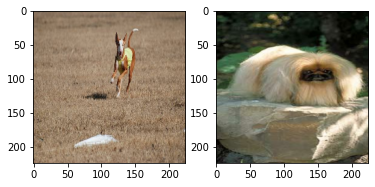

In [8]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

두 개의 이미지를 얻었습니다.

이 중 첫 번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두 번째 이미지 b가 있을 때, a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수를 먼저 구현해 봅시다.

이번 노드에서는 이미지 a, b가 모두 (224, 224)로 resize되어 두 이미지의 width, height가 같은 경우로 가정할 수 있지만, CutMix 공식 repo 에서는 width, height가 다르더라도 가변적으로 적용할 수 있도록 구현되어 있기 때문에, 임의의 이미지 사이즈에 대해서도 유연하게 대응 가능하도록 구현해 보겠습니다.

In [9]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(139, shape=(), dtype=int32)
y :  tf.Tensor(44, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


바탕이미지 image_a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수를 구현해 봅시다.

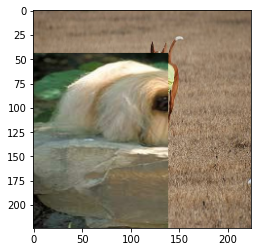

In [10]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    # image_b의 왼쪽 바깥 영역
    middle_left = image_a[y_min:y_max, 0:x_min, :]

    # image_b의 안쪽 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  

    # image_b의 오른쪽 바깥 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :]
    
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

#### 2) 라벨 섞기
이미지를 섞었다면 라벨도 이에 맞게 섞어주어야 합니다. 그림에서 볼 수 있듯, 우리가 강아지와 고양이의 이미지를 섞었다면 라벨 또한 적절한 비율로 섞여야 합니다.

CutMix에서는 면적에 비례해서 라벨을 섞어줍니다. 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두 가지 라벨의 비율로 더해줍니다. 예를 들어 A 클래스를 가진 원래 이미지 image_a와 B 클래스를 가진 이미지 image_b를 섞을 때 image_a를 0.4만큼 섞었을 경우, 0.4만큼의 클래스 A, 0.6만큼의 클래스 B를 가지도록 해줍니다. 이때 라벨 벡터는 보통 클래스를 표시하듯 클래스 1개만 1의 값을 가지는 원-핫 인코딩이 아니라 A와 B 클래스에 해당하는 인덱스에 각각 0.4, 0.6을 배분하는 방식을 사용합니다.

위에서 섞인 이미지 두 가지에 대하여 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수를 구현해 봅시다.

In [11]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.49864477, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.50135523, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

이제 거의다 준비되었습니다.
위에서 구현한 두 함수 mix_2_images()와 mix_2_label()을 활용하여 배치 단위의 cutmix() 함수를 구현해 봅시다.

In [12]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### (2) Mixup Augmentation
Mixup은 앞에서 보여드린 CutMix보다 간단하게 이미지와 라벨을 섞어줍니다. 아래 참고자료는 앞에서 본 CutMix 비교표에서 "Mixup"이라는 방법이 제안된 논문입니다. 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로 CutMix보다 구현이 간단하다고 볼 수 있습니다. 아래에서 직접 Mixup 함수를 구현해보세요!

* [mixup:Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412)

두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어주면 됩니다.

![img](https://d3s0tskafalll9.cloudfront.net/media/images/GC-2-P-3.max-800x600.png)

In [13]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

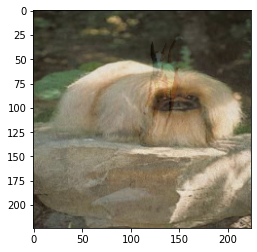

tf.Tensor(
[0.         0.         0.         0.7244942  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.27550578 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [14]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [15]:
# 배치 단위의 mixup() 함수를 구현
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

*****

## 프로젝트: CutMix 또는 Mixup 비교실험 하기
지금까지 기본적인 augmentation 방법을 적용해 모델을 훈련시키고, 최신 augmentation 기법을 배워 보았습니다.

이번에는 최신 기법(CutMix 또는 Mixup)을 적용해 모델을 훈련시켜 봅시다. 데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시켜 주세요. 결과를 수치화하고 비교하는 것도 잊지 마세요!

우선 주요 라이브러리 버전을 확인해 볼까요?

In [16]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


### 1. Augmentation을 적용한 데이터셋 만들기
이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.

* Q1. 아래는 CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset()입니다. batch() 함수 뒤에 CutMix가 오도록 만들어야합니다. 그 이유가 뭘까요?
- CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 합니다.

In [17]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

In [18]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [19]:
# augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋 생성
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

### 2. 모델 만들기

#### No Augmentation

In [20]:
no_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')  # 데이터에 맞는 FC layer 붙여서 활용
])

94781440/94765736 [==============================] - 1s 0us/step


#### Augmentation

In [21]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

#### CutMix Augmentation

In [22]:
cutmix_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

#### Mixup Augmentation

In [23]:
mixup_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

### 3. 모델 훈련하기
모델을 훈련시켜 주세요.

주의!! 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해 주세요!

* Q2. sparse_categorical_crossentropy()를 사용하지 못하는 이유가 뭘까요?
- 우리가 cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문

In [24]:
EPOCH = 20
tf.random.set_seed(0)

no_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

cutmix_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

mixup_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


#### No Augmentation

In [25]:
his_no_aug_resnet50 = no_aug_resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 171s 204ms/step - loss: 2.2356 - accuracy: 0.4434 - val_loss: 3.0547 - val_accuracy: 0.2599
Epoch 2/20
750/750 [==============================] - 158s 211ms/step - loss: 0.6908 - accuracy: 0.8120 - val_loss: 1.0593 - val_accuracy: 0.6880
Epoch 3/20
750/750 [==============================] - 160s 214ms/step - loss: 0.1905 - accuracy: 0.9668 - val_loss: 0.9399 - val_accuracy: 0.7267
Epoch 4/20
750/750 [==============================] - 160s 214ms/step - loss: 0.0486 - accuracy: 0.9968 - val_loss: 0.9021 - val_accuracy: 0.7396
Epoch 5/20
750/750 [==============================] - 161s 214ms/step - loss: 0.0202 - accuracy: 0.9998 - val_loss: 0.9144 - val_accuracy: 0.7416
Epoch 6/20
750/750 [==============================] - 160s 214ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 0.9316 - val_accuracy: 0.7397
Epoch 7/20
750/750 [==============================] - 160s 213ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.9473 -

#### Augmentation

In [26]:
his_aug_resnet50 = aug_resnet50.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 166s 212ms/step - loss: 2.3101 - accuracy: 0.4223 - val_loss: 3.1270 - val_accuracy: 0.2417
Epoch 2/20
750/750 [==============================] - 159s 213ms/step - loss: 0.9333 - accuracy: 0.7358 - val_loss: 1.4609 - val_accuracy: 0.5821
Epoch 3/20
750/750 [==============================] - 160s 214ms/step - loss: 0.4784 - accuracy: 0.8701 - val_loss: 1.0193 - val_accuracy: 0.6955
Epoch 4/20
750/750 [==============================] - 160s 213ms/step - loss: 0.2482 - accuracy: 0.9444 - val_loss: 1.1170 - val_accuracy: 0.6802
Epoch 5/20
750/750 [==============================] - 160s 214ms/step - loss: 0.1310 - accuracy: 0.9770 - val_loss: 1.0517 - val_accuracy: 0.7048
Epoch 6/20
750/750 [==============================] - 161s 215ms/step - loss: 0.0697 - accuracy: 0.9918 - val_loss: 1.0037 - val_accuracy: 0.7240
Epoch 7/20
750/750 [==============================] - 161s 215ms/step - loss: 0.0415 - accuracy: 0.9957 - val_loss: 0.9691 -

#### CutMix Augmentation

In [27]:
his_cutmix_aug_resnet50 = cutmix_aug_resnet50.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 168s 215ms/step - loss: 3.8410 - accuracy: 0.2045 - val_loss: 3.6172 - val_accuracy: 0.1740
Epoch 2/20
750/750 [==============================] - 174s 232ms/step - loss: 2.9763 - accuracy: 0.4296 - val_loss: 1.4781 - val_accuracy: 0.5992
Epoch 3/20
750/750 [==============================] - 160s 213ms/step - loss: 2.6574 - accuracy: 0.5274 - val_loss: 1.2931 - val_accuracy: 0.6376
Epoch 4/20
750/750 [==============================] - 161s 214ms/step - loss: 2.4473 - accuracy: 0.5978 - val_loss: 1.2137 - val_accuracy: 0.6733
Epoch 5/20
750/750 [==============================] - 161s 215ms/step - loss: 2.2698 - accuracy: 0.6557 - val_loss: 1.2556 - val_accuracy: 0.6562
Epoch 6/20
750/750 [==============================] - 161s 215ms/step - loss: 2.1523 - accuracy: 0.6903 - val_loss: 1.2431 - val_accuracy: 0.6670
Epoch 7/20
750/750 [==============================] - 161s 214ms/step - loss: 2.0468 - accuracy: 0.7223 - val_loss: 1.2267 -

#### Mixup Augmentation

In [28]:
his_mixup_aug_resnet50 = mixup_aug_resnet50.fit(
    ds_train_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 168s 215ms/step - loss: 2.2166 - accuracy: 0.4412 - val_loss: 3.4365 - val_accuracy: 0.2015
Epoch 2/20
750/750 [==============================] - 160s 213ms/step - loss: 0.6810 - accuracy: 0.8138 - val_loss: 1.1059 - val_accuracy: 0.6739
Epoch 3/20
750/750 [==============================] - 173s 231ms/step - loss: 0.1921 - accuracy: 0.9627 - val_loss: 0.9454 - val_accuracy: 0.7201
Epoch 4/20
750/750 [==============================] - 160s 213ms/step - loss: 0.0485 - accuracy: 0.9969 - val_loss: 0.9205 - val_accuracy: 0.7358
Epoch 5/20
750/750 [==============================] - 160s 214ms/step - loss: 0.0196 - accuracy: 0.9998 - val_loss: 0.9264 - val_accuracy: 0.7388
Epoch 6/20
750/750 [==============================] - 160s 214ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.9384 - val_accuracy: 0.7366
Epoch 7/20
750/750 [==============================] - 161s 214ms/step - loss: 0.0123 - accuracy: 0.9997 - val_loss: 0.9718 -

### 4. 훈련 과정 시각화하기
훈련 과정의 히스토리를 그래프로 시각화해 주세요.

#### Accuracy

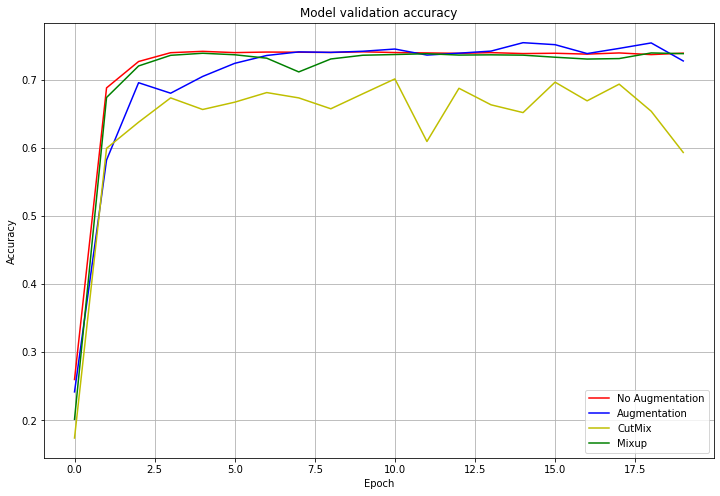

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(his_no_aug_resnet50.history['val_accuracy'], 'r')
plt.plot(his_aug_resnet50.history['val_accuracy'], 'b')
plt.plot(his_cutmix_aug_resnet50.history['val_accuracy'], 'y')
plt.plot(his_mixup_aug_resnet50.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'CutMix', 'Mixup'], loc='lower right')
plt.grid(True)
plt.show()

#### Loss

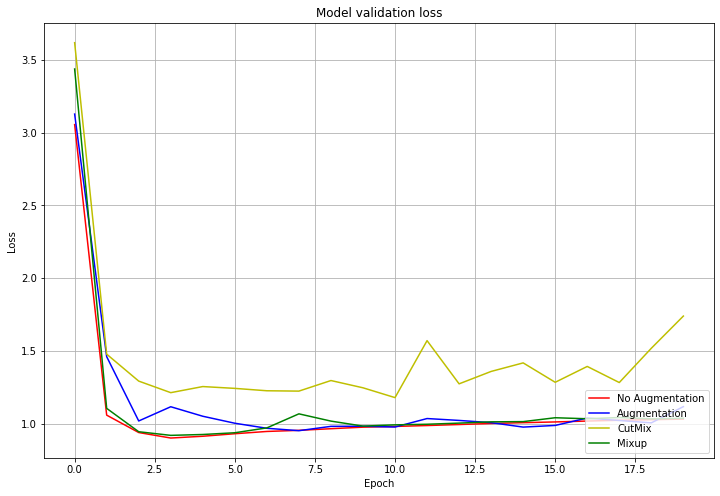

In [30]:
plt.figure(figsize=(12, 8))
plt.plot(his_no_aug_resnet50.history['val_loss'], 'r')
plt.plot(his_aug_resnet50.history['val_loss'], 'b')
plt.plot(his_cutmix_aug_resnet50.history['val_loss'], 'y')
plt.plot(his_mixup_aug_resnet50.history['val_loss'], 'g')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'CutMix', 'Mixup'], loc='lower right')
plt.grid(True)
plt.show()

In [31]:
acc_data = {'No Augmentation': his_no_aug_resnet50.history['val_loss'], 
            'Augmentation': his_aug_resnet50.history['val_loss'], 
            'CutMix': his_cutmix_aug_resnet50.history['val_loss'], 
            'Mixup': his_mixup_aug_resnet50.history['val_loss']}
acc_df = pd.DataFrame(acc_data)
acc_df

,No Augmentation,Augmentation,CutMix,Mixup
0,3.054673,3.126998,3.617248,3.436542
1,1.059334,1.460943,1.478143,1.105890
2,0.939856,1.019310,1.293147,0.945370
3,0.902110,1.116994,1.213719,0.920460
4,0.914363,1.051712,1.255609,0.926434
5,0.931636,1.003704,1.243119,0.938376
6,0.947294,0.969087,1.226727,0.971788
7,0.954927,0.952584,1.224351,1.068208
8,0.966144,0.982324,1.296951,1.018370
9,0.976759,0.983270,1.247135,0.983957


### 5. Augmentation에 의한 모델 성능 비교
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

In [32]:
import pandas as pd

In [33]:
acc_data = {'No Augmentation': his_no_aug_resnet50.history['val_accuracy'], 
            'Augmentation': his_aug_resnet50.history['val_accuracy'], 
            'CutMix': his_cutmix_aug_resnet50.history['val_accuracy'], 
            'Mixup': his_mixup_aug_resnet50.history['val_accuracy']}
acc_df = pd.DataFrame(acc_data)
acc_df

,No Augmentation,Augmentation,CutMix,Mixup
0,0.259911,0.241721,0.173974,0.201493
1,0.687966,0.582090,0.599230,0.673857
2,0.726679,0.695546,0.637593,0.720149
3,0.739622,0.680154,0.673274,0.735774
4,0.741605,0.704757,0.656250,0.738806
5,0.739739,0.723997,0.666978,0.736591
6,0.740555,0.735541,0.681087,0.731577
7,0.740322,0.740788,0.673274,0.711404
8,0.739972,0.740089,0.657299,0.730410
9,0.740905,0.741721,0.679338,0.735891


## 회고

**1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?**
- CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.


**2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?**
- Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함


**3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?**
- 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.

*****

초반에 계속 알 수 없는 에러로 인해 끙끙거리다가 구글링의 도움으로 해결하게 되어 뿌듯했다.(퍼실님의 헬프없이 구글링으로 해결..!!)

```
typeerror: tf__normalize_and_resize_img() missing 1 required positional argument: 'label'
# 해결!

ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, None, 224, 224, 3)
# 필사하다가 생긴 에러 해결 못함..;;
```



*****

**Augmentaion 미적용 vs 기본 Augmentaion**
- 기본 Augmentaion이 미세하게 정확도 더 높다.

**기본 Augmentation vs CutMix vs Mixup**
- 기본 Augmentaion이 성능이 가장 좋다.



- Augmentaion 미적용한 것 보다 Augmentation 적용시 정확도가 향상됬다.
- Accuracy 그래프로 보면 CutMix와 Mixup이 Augmentation 적용했을 때보다 더 낮았다.
- Loss 그래프도 CutMix와 Mixup이 더 안 좋았다.
(CutMix 와 Mixup 과정에서 개의 부분이 아니라 랜덤으로 바운딩박스의 위치를 뽑아서 모델이 학습하는 데에 악영향을 미친것으로 예상된다.)